In [1]:
import os
import numpy as np
import importlib

import torch
from torch.utils.data import DataLoader

from utils.common import plot_hist_seaborn, plot_ROC_curve, read_annotations, load_config
from utils.evaluation import evaluate_multiclass, metric_ood, compute_oscr
from data.dataset import ImageDataset
from models.models import Simple_CNN

In [2]:
def get_feature(model, dataloader, config, device):
    model.eval()
    Loss = importlib.import_module('loss.' + config.loss)
    criterion = getattr(Loss, config.loss)(config).to(device)
    with torch.no_grad():
        features = []
        labels =[]
        probs=[]
        for i, batch in enumerate(dataloader):
            input_img_batch, label_batch, _ = batch 
            input_img = input_img_batch.reshape((-1, 3, input_img_batch.size(-2), input_img_batch.size(-1))).to(device)
            label = label_batch.reshape((-1)).to(device)
            prob, feature = model(input_img, data='dct')
            prob, _ = criterion(feature, prob)

            if i == 0:
                probs = prob
                gt_labels = label
                features = feature
            else:
                probs = torch.cat([probs, prob], dim=0)
                gt_labels = torch.cat([gt_labels, label])
                features=torch.cat(([features, feature]))

    features = features.cpu().numpy()
    probs = probs.cpu().numpy()
    labels = gt_labels.cpu().numpy()
        
    return features, labels, probs

In [3]:
def calculate_open_set_result(_labels_k, _labels_u, _pred_k, _pred_u, known_feature, unknown_feature, known_classes, unknown_classes, save_dir):
    
    x1, x2 = np.max(_pred_k, axis=1), np.max(_pred_u, axis=1)
    out_results = metric_ood(x1, x2)['Bas'] # check
    _oscr_socre = compute_oscr(_pred_k, _pred_u, _labels_k)
    unknown_perf = round(out_results['AUROC'], 2)

    print("AUC, OSCR : {:.2f} {:.2f}".format(unknown_perf, _oscr_socre*100))

    # plot confidence histogram and ROC curve
    os.makedirs(save_dir, exist_ok=True)
    plot_hist_seaborn(x1, x2, save_path = os.path.join(save_dir,'hist.png'))
    plot_ROC_curve(out_results, save_path = os.path.join(save_dir,'roc.png'))
    
    # print detailed results for each unknown class
    for i, label_u in enumerate(set(_labels_u)):
        pred_u = _pred_u[_labels_u==label_u]
        x1, x2 = np.max(_pred_k, axis=1), np.max(pred_u, axis=1)
        pred = np.argmax(pred_u, axis=1)
        pred_labels = list(set(pred))
        pred_nums = [np.sum(pred==p) for p in pred_labels]
        result = metric_ood(x1, x2, verbose=False)['Bas']
        print("{}\t \t mostly pred class: {}\t \t average score: {}\t AUROC (%): {:.2f}".format(unknown_classes[i], 
                                                                                 known_classes[pred_labels[np.argmax(pred_nums)]],
                                                                                 np.mean(x2), result['AUROC']))

In [4]:
device = 'cuda:3'
config = load_config('configs.{}'.format('progressive'))

# load model
model_path = './checkpoints/split1/model.pth'
model = Simple_CNN(class_num=15, out_feature_result=True)
pretrained_dict = torch.load(model_path, map_location='cpu')['state_dict']
model.load_state_dict(pretrained_dict)
model = model.to(device)

In [5]:
test_data_path = '/home/lihao/python_proj/AIGC_2025/others_work/POSE/dataset/split1_test/annotations/split1_test.txt'
close_set = ImageDataset(read_annotations(test_data_path), config, balance=False, test_mode=True)
close_loader = DataLoader(
    dataset=close_set,
    num_workers=config.num_workers,
    batch_size=config.batch_size,
    pin_memory=True,
    shuffle=True,
    drop_last=False,
)
known_feature, known_label, known_prob  = get_feature(model, close_loader, config, device)
pred_labels = np.argmax(known_prob, axis=1)
results = evaluate_multiclass(known_label, pred_labels)
print('closed-set accuracy', round(results['acc'], 4)*100)

/home/lihao/python_proj/AIGC_2025/others_work/POSE/loss/Softmax.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = F.softmax(logits)


closed-set accuracy 91.7


/home/lihao/python_proj/AIGC_2025/others_work/POSE/loss/Softmax.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = F.softmax(logits)


       TNR    AUROC  DTACC  AUIN   AUOUT 
Bas    46.959 90.752 83.766 70.398 98.516
AUC, OSCR : 90.75 84.63


/home/lihao/python_proj/AIGC_2025/others_work/POSE/utils/common.py:89: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(d, shade=True, alpha=.3, label=legend)
/home/lihao/python_proj/AIGC_2025/others_work/POSE/utils/common.py:89: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(d, shade=True, alpha=.3, label=legend)


ADM	 	 mostly pred class: real	 	 average score: 0.29429522156715393	 AUROC (%): 95.64
stable_diffusion_v_1_5	 	 mostly pred class: real	 	 average score: 0.35627108812332153	 AUROC (%): 91.85
stable_diffusion_v_1_4	 	 mostly pred class: real	 	 average score: 0.35271286964416504	 AUROC (%): 92.12
glide	 	 mostly pred class: stylegan_cat	 	 average score: 0.47955718636512756	 AUROC (%): 79.81
wukong	 	 mostly pred class: real	 	 average score: 0.3449532091617584	 AUROC (%): 92.61
VQDM	 	 mostly pred class: real	 	 average score: 0.36503100395202637	 AUROC (%): 91.08
Midjourney	 	 mostly pred class: real	 	 average score: 0.3798658549785614	 AUROC (%): 89.91
ldm-text2im-large-256	 	 mostly pred class: real	 	 average score: 0.3486987352371216	 AUROC (%): 92.47
controlnet-canny-sdxl-1.0	 	 mostly pred class: real	 	 average score: 0.40783384442329407	 AUROC (%): 87.91
lcm-lora-sdv1-5	 	 mostly pred class: real	 	 average score: 0.38673368096351624	 AUROC (%): 89.65
sd-turbo	 	 mostly pre

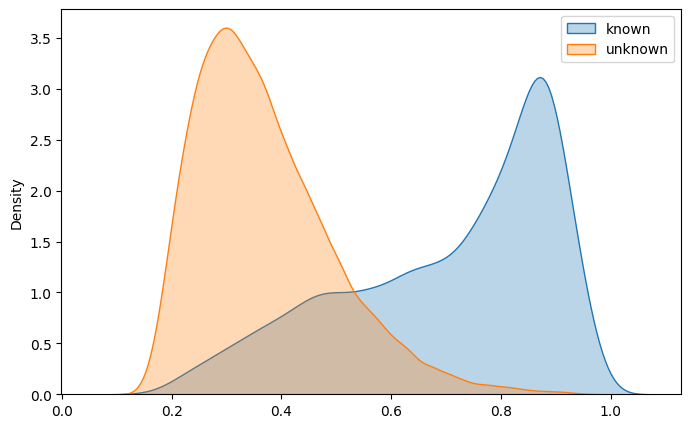

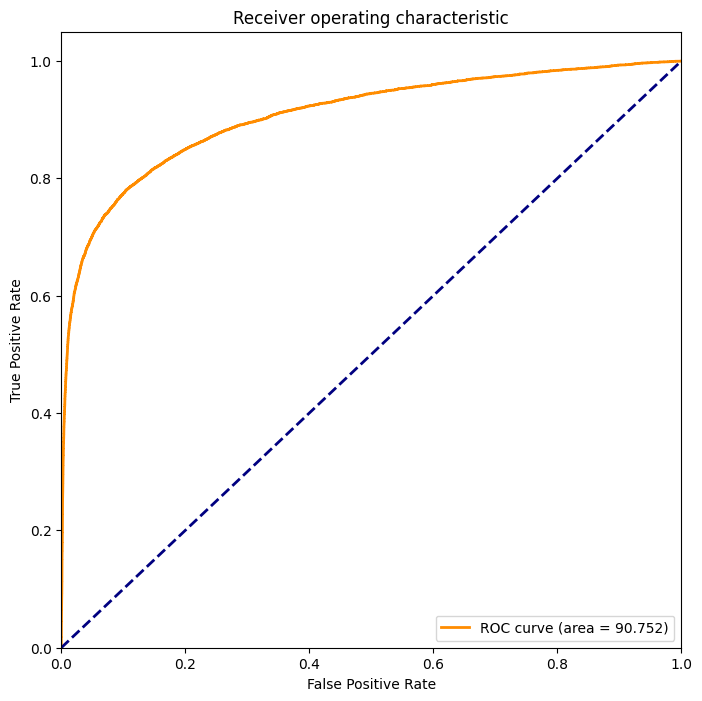

In [7]:
out_data_path = '/home/lihao/python_proj/AIGC_2025/others_work/POSE/dataset/diffusion_test/train_out.txt'
out_set = ImageDataset(read_annotations(out_data_path), config, balance=False, test_mode=True)
out_loader = DataLoader(
    dataset=out_set,
    num_workers=config.num_workers,
    batch_size=config.batch_size,
    pin_memory=True,
    shuffle=True,
    drop_last=False,
)
out_feature, out_label, out_prob  = get_feature(model, out_loader, config, device)
known_classes = ['real', 'celeba_ProGAN_seed0', 'celeba_StarGAN', 'FFHQ_StyleGAN3_r', 'FFHQ_StyleGAN3_t', 'SNGAN_imagenet', 'SAGAN_imagenet', 'lsun_ProGAN_seed0', 'lsun_MMDGAN', 'FaceSwap', 'FSGAN', 'stylegan_cat', 'stylegan3_cat', 'stylegan_bus', 'progan_bus']
unknown_classes = ['ADM',
 'stable_diffusion_v_1_5',
 'stable_diffusion_v_1_4',
 'glide',
 'wukong',
 'VQDM',
 'Midjourney',
 'ldm-text2im-large-256',
 'controlnet-canny-sdxl-1.0',
 'lcm-lora-sdv1-5',
 'sd-turbo',
 'sdxl-turbo',
 'stable-diffusion-xl-base-1.0',
 'stable-diffusion-xl-refiner-1.0',
 'stable-diffusion-2-1']
calculate_open_set_result(known_label, out_label, known_prob, out_prob, known_feature, out_feature, known_classes, unknown_classes, './results/unseen_diffusion')


In [14]:
len(known_classes)

15

In [8]:
from utils.evaluation import metric_cluster
features = np.concatenate([known_feature, out_feature])
labels = np.concatenate([known_label,  out_label+len(known_label)]) # 避免重复
class_num = len(set(known_label)) + len(set(out_label))
NMI, cluster_acc, purity = metric_cluster(features, class_num, labels, 'minibatch_kmeans')
print("NMI: {:.2f}, cluster_acc: {:.2f}, purity: {:.2f}".format(NMI, cluster_acc, purity))

Data points 83000 Clusters 30
Average purity: 0.2383 NMI: 0.2305 ARI: 0.0564 
NMI: 0.23, cluster_acc: 0.24, purity: 0.06


<Figure size 640x480 with 0 Axes>

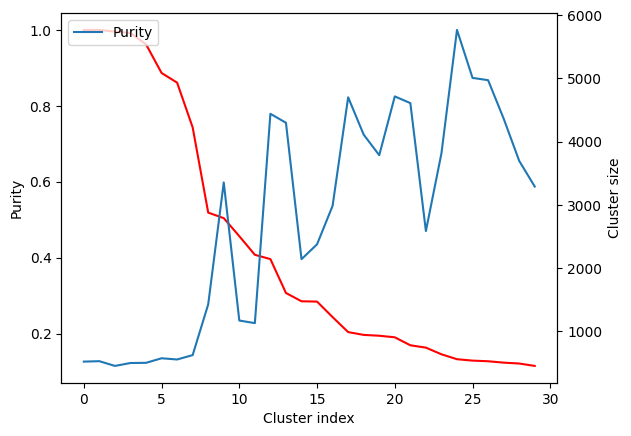

Data points 83000 Clusters 30
Average purity: 0.2528 NMI: 0.2341 ARI: 0.0626 
GCD acc: 0.20195180722891568


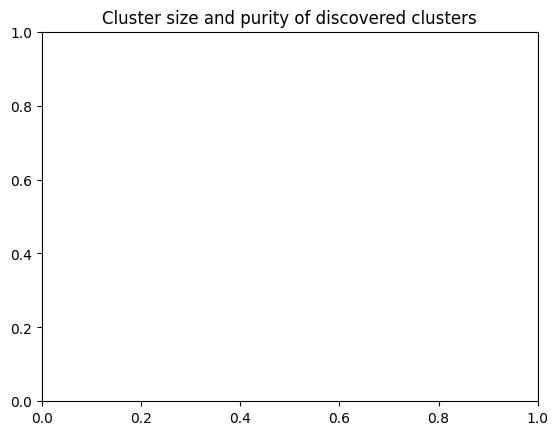

In [12]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_rand_score
from sklearn.cluster import KMeans, DBSCAN, MiniBatchKMeans
from sklearn.metrics import accuracy_score, recall_score, f1_score
def metric_cluster(X_selected, n_clusters, y, cluster_method='kmeans',path='./cluster_res'):
    """
    This function calculates ARI, ACC and NMI of clustering results
    Input
    -----
    X_selected: {numpy array}, shape (n_samples, n_selected_features}
            input data on the selected features
    n_clusters: {int}
            number of clusters
    y: {numpy array}, shape (n_samples,)
            true labels
    Output
    ------
    nmi: {float}
        Normalized Mutual Information
    acc: {float}
        Accuracy
    """
    if cluster_method == 'kmeans':
        cluster_alg = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=300,
                     tol=0.0001, precompute_distances=True, verbose=0,
                     random_state=None, copy_x=True, n_jobs=1)
    elif cluster_method == 'minibatch_kmeans':
        cluster_alg = MiniBatchKMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, batch_size=2048)
    elif cluster_method == 'dbscan':
        cluster_alg = DBSCAN(eps=3, min_samples=2)
    else:
        raise ValueError('select kmeans or dbscan for cluster')

    cluster_alg.fit(X_selected)
    y_predict = cluster_alg.labels_

    # # from openworld-gan, same as above
    nmi, purity, ari = cluster_stats(y_predict, y, path)

    return nmi, purity, ari

from scipy.optimize import linear_sum_assignment as linear_assignment
import numpy as np

def cal_cluster_acc(y_true, y_pred, return_ind=False):
    """
    Calculate clustering accuracy. Require scikit-learn installed

    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`

    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(int)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=int)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1

    ind = linear_assignment(w.max() - w)
    ind = np.vstack(ind).T

    if return_ind:
        return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size, ind, w
    else:
        return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size
    
def metric_GCD(X_selected, n_clusters, y, cluster_method='kmeans',path='./cluster_res'):
    """
    This function calculates ACC in GCD of clustering results
    Input
    -----
    X_selected: {numpy array}, shape (n_samples, n_selected_features}
            input data on the selected features
    n_clusters: {int}
            number of clusters
    y: {numpy array}, shape (n_samples,)
            true labels
    Output
    ------
    nmi: {float}
        Normalized Mutual Information
    acc: {float}
        Accuracy
    """
    if cluster_method == 'kmeans':
        cluster_alg = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=300,
                     tol=0.0001, precompute_distances=True, verbose=0,
                     random_state=None, copy_x=True, n_jobs=1)
    elif cluster_method == 'minibatch_kmeans':
        cluster_alg = MiniBatchKMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, batch_size=2048)
    elif cluster_method == 'dbscan':
        cluster_alg = DBSCAN(eps=3, min_samples=2)
    else:
        raise ValueError('select kmeans or dbscan for cluster')

    cluster_alg.fit(X_selected)
    y_predict = cluster_alg.labels_

    return cal_cluster_acc(y,y_predict)

def cluster_stats(predicted, targets, save_path=None):
    n_clusters = np.unique(predicted).size
    n_classes  = np.unique(targets).size
    num = np.zeros([n_clusters,n_classes])
    unique_targets = np.unique(targets)
    for i,p in enumerate(np.unique(predicted)):
        class_labels = targets[predicted==p]
        num[i,:] = np.sum(class_labels[:,np.newaxis]==unique_targets[np.newaxis,:],axis=0)
    sum_clusters = np.sum(num,axis=1)
    purity = np.max(num,axis=1)/(sum_clusters+(sum_clusters==0).astype(sum_clusters.dtype))
    indices = np.argsort(-purity)

    if save_path is not None:
        plt.clf()
        fig, ax1 = plt.subplots()
        ax1.plot(purity[indices],color='red')
        ax1.set_xlabel('Cluster index')
        ax1.set_ylabel('Purity')
        ax2 = ax1.twinx()
        ax2.plot(sum_clusters[indices])
        ax2.set_ylabel('Cluster size')
        plt.legend(('Purity','Cluster size'))
        plt.show()
        plt.title('Cluster size and purity of discovered clusters')
        plt.savefig(save_path)
    print('Data points {} Clusters {}'.format(np.sum(sum_clusters).astype(np.int64), n_clusters))
    print('Average purity: {:.4f} '.format(np.sum(purity*sum_clusters)/np.sum(sum_clusters))+\
          'NMI: {:.4f} '.format(normalized_mutual_info_score(targets, predicted))+\
          'ARI: {:.4f} '.format(adjusted_rand_score(targets, predicted)))
    avg_purity = np.sum(purity*sum_clusters)/np.sum(sum_clusters) 
    nmi = normalized_mutual_info_score(targets, predicted) 
    ari = adjusted_rand_score(targets, predicted) 
    return nmi, avg_purity, ari
features = np.concatenate([known_feature, out_feature])
labels = np.concatenate([known_label,  out_label+len(known_label)]) # 避免重复
class_num = len(set(known_label)) + len(set(out_label))
NMI, cluster_acc, purity = metric_cluster(features, class_num, labels, 'minibatch_kmeans')

ACC_GCD = metric_GCD(features, class_num, labels, 'minibatch_kmeans')
print(f"GCD acc: {ACC_GCD}")
# print("NMI: {:.2f}, cluster_acc: {:.2f}, purity: {:.2f}".format(NMI, cluster_acc, purity))